In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
%matplotlib inline

from pydoc import help
from scipy.stats.stats import pearsonr

from sklearn import datasets, linear_model
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

from datetime import datetime
from datetime import timedelta
import datetime as dt
import calendar

import math

<ipython-input-77-6ab982f88044>:9: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [78]:
taxi = pd.read_csv("https://raw.githubusercontent.com/Premalatha-success/Datasets/main/TaxiFare.csv")
taxi.columns

Index(['unique_id', 'amount', 'date_time_of_pickup', 'longitude_of_pickup',
       'latitude_of_pickup', 'longitude_of_dropoff', 'latitude_of_dropoff',
       'no_of_passenger'],
      dtype='object')

In [79]:
#Checking Null entries
taxi[pd.isnull(taxi)].sum()

unique_id                 0
amount                  0.0
date_time_of_pickup       0
longitude_of_pickup     0.0
latitude_of_pickup      0.0
longitude_of_dropoff    0.0
latitude_of_dropoff     0.0
no_of_passenger         0.0
dtype: object

In [80]:
#Extracting data from date_time_of_pickup in dataset

taxi['date_time_of_pickup'] = pd.to_datetime(taxi['date_time_of_pickup'], format = '%Y-%m-%d %H:%M:%S UTC')
taxi['pickup_date']= taxi['date_time_of_pickup'].dt.date
taxi['pickup_hour']=taxi['date_time_of_pickup'].dt.hour
taxi['pickup_day']=taxi['date_time_of_pickup'].dt.day
taxi['pickup_month']=taxi['date_time_of_pickup'].dt.month
taxi['pickup_year']=taxi['date_time_of_pickup'].dt.year
taxi['pickup_day_of_week']=taxi['date_time_of_pickup'].apply(lambda x:calendar.day_name[x.weekday()])

In [81]:
print (taxi.shape)
print (taxi.columns)

(50000, 14)
Index(['unique_id', 'amount', 'date_time_of_pickup', 'longitude_of_pickup',
       'latitude_of_pickup', 'longitude_of_dropoff', 'latitude_of_dropoff',
       'no_of_passenger', 'pickup_date', 'pickup_hour', 'pickup_day',
       'pickup_month', 'pickup_year', 'pickup_day_of_week'],
      dtype='object')


In [82]:
# REMOVING ENTRIES WITH -VE FARE AMOUNT
taxi=taxi.loc[taxi['amount']>=0]
print (taxi.shape)

(49994, 14)


In [83]:
test = pd.read_csv("/content/test.csv")

In [84]:
test =  pd.read_csv('./test.csv')

print("Longitude Boundary in test data")
print (min(test.pickup_longitude.min(), test.dropoff_longitude.min()),max(test.pickup_longitude.max(), test.dropoff_longitude.max()))

print("Latitude Boundary in test data")
print (min(test.pickup_latitude.min(), test.pickup_latitude.min()),max(test.pickup_latitude.max(), test.pickup_latitude.max()))

Longitude Boundary in test data
-74.263242 -72.986532
Latitude Boundary in test data
40.573143 41.709555


In [85]:
boundary={'north_lat':41.709555,
          'south_lat':40.573143,
          'east_long':-72.986532, 
          'west_long':-74.263242}

In [86]:
taxi.loc[~((taxi.longitude_of_pickup >= boundary['west_long'] ) & (taxi.longitude_of_pickup <= boundary['east_long']) &
            (taxi.latitude_of_pickup >= boundary['south_lat']) & (taxi.latitude_of_pickup <= boundary['north_lat']) &
            (taxi.longitude_of_dropoff >= boundary['west_long']) & (taxi.longitude_of_dropoff <= boundary['east_long']) &
            (taxi.latitude_of_dropoff >=boundary['south_lat']) & (taxi.latitude_of_dropoff <= boundary['north_lat'])),'is_outlier_loc']=1
taxi.loc[((taxi.longitude_of_pickup >= boundary['west_long'] ) & (taxi.longitude_of_pickup <= boundary['east_long']) &
            (taxi.latitude_of_pickup >= boundary['south_lat']) & (taxi.latitude_of_pickup <= boundary['north_lat']) &
            (taxi.longitude_of_dropoff >= boundary['west_long']) & (taxi.longitude_of_dropoff <= boundary['east_long']) &
            (taxi.latitude_of_dropoff >=boundary['south_lat']) & (taxi.latitude_of_dropoff <= boundary['north_lat'])),'is_outlier_loc']=0

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [87]:
taxi=taxi.loc[taxi['is_outlier_loc']==0]
taxi.drop(['is_outlier_loc'],axis=1,inplace=True)
print (taxi.shape)

(48922, 14)


In [88]:
def haversian_distance(lat1, lat2, lon1,lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

taxi['hav_distance'] = taxi.apply(lambda row:haversian_distance(row['latitude_of_pickup'],row['latitude_of_dropoff'],row['longitude_of_pickup'],row['longitude_of_dropoff']),axis=1)

In [89]:
taxi['euc_distance'] = 69 * np.sqrt((np.array(taxi.longitude_of_dropoff) - np.array(taxi.longitude_of_pickup))**2 + (np.array(taxi.latitude_of_pickup) - np.array(taxi.latitude_of_dropoff))**2)

In [90]:
print ("Corr between Eucledian Distance and Fare Amount")
corr = pearsonr(taxi.amount, taxi.euc_distance)
print (corr)

Corr between Eucledian Distance and Fare Amount
PearsonRResult(statistic=0.7990354311844969, pvalue=0.0)


Text(17.67500000000001, 0.5, 'Taxi Fare')

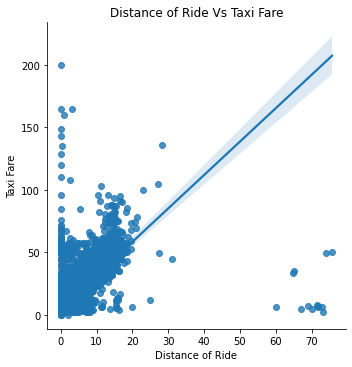

In [91]:
# Scatter Plot Between Eucledian Distance and Fare Amount
sns.lmplot(x='euc_distance', y='amount', data=taxi)
plt.title('Distance of Ride Vs Taxi Fare')
plt.xlabel('Distance of Ride')
plt.ylabel('Taxi Fare')

Text(17.67500000000001, 0.5, 'Taxi Fare')

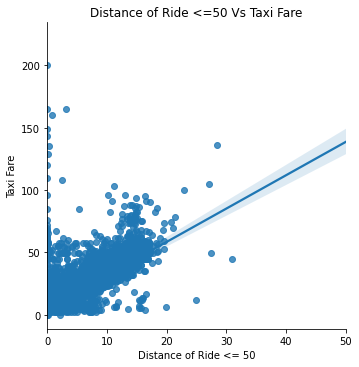

In [92]:
# Scatter Plot Between Eucledian Distance <=50 and Fare Amount
lm = sns.lmplot(x='euc_distance', y='amount', data=taxi)
lm.set(xlim=(0, 50))
plt.title('Distance of Ride <=50 Vs Taxi Fare')
plt.xlabel('Distance of Ride <= 50')
plt.ylabel('Taxi Fare')

In [93]:
print ("Corr between Time of the Day and Eucledian Distance")
corr = pearsonr(taxi.euc_distance, taxi.pickup_hour)
print (corr)

Corr between Time of the Day and Eucledian Distance
PearsonRResult(statistic=-0.03260097433060624, pvalue=5.492575957297629e-13)


Text(24.956249999999997, 0.5, 'Distance of Ride')

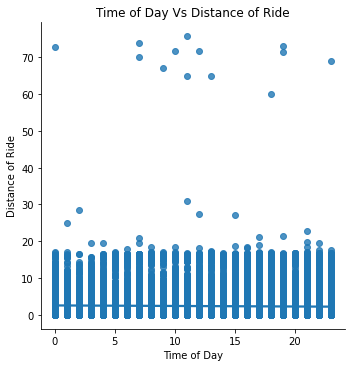

In [94]:
# Scatter Plot Between Eucledian Distance and Time of the Day

sns.lmplot(x='pickup_hour', y='euc_distance', data=taxi)

plt.title('Time of Day Vs Distance of Ride')
# Set x-axis label
plt.xlabel('Time of Day')
# Set y-axis label
plt.ylabel('Distance of Ride')

In [95]:
print ("Corr between Fare Amount and all other parameters")
print (taxi.corr('pearson')["amount"])

Corr between Fare Amount and all other parameters
amount                  1.000000
longitude_of_pickup     0.393789
latitude_of_pickup     -0.167788
longitude_of_dropoff    0.314693
latitude_of_dropoff    -0.141144
no_of_passenger         0.016258
pickup_hour            -0.021941
pickup_day             -0.001918
pickup_month            0.026755
pickup_year             0.121098
hav_distance            0.789268
euc_distance            0.799035
Name: amount, dtype: float64


In [96]:
print ("Corr between Haversian Distance and all other parameters")
print (taxi.corr('pearson')["hav_distance"])

Corr between Haversian Distance and all other parameters
amount                  0.789268
longitude_of_pickup     0.446148
latitude_of_pickup     -0.092954
longitude_of_dropoff    0.350614
latitude_of_dropoff    -0.093751
no_of_passenger         0.012407
pickup_hour            -0.033041
pickup_day             -0.000244
pickup_month            0.010439
pickup_year             0.017588
hav_distance            1.000000
euc_distance            0.994156
Name: hav_distance, dtype: float64


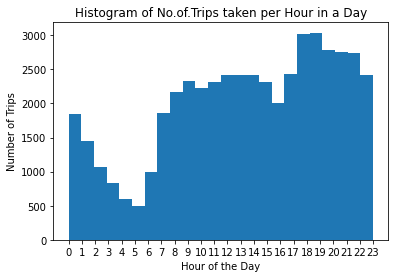

In [97]:
# Histogram of No.of.Trips taken per Hour in a Day
plt.hist(taxi.pickup_hour, bins=24)
plt.xticks(np.arange(0,24,step=1))
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.title('Histogram of No.of.Trips taken per Hour in a Day')
plt.show()

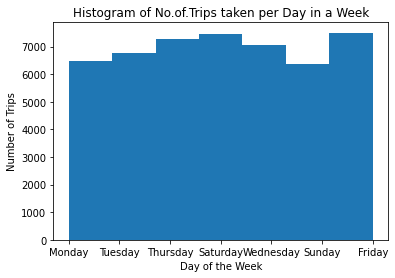

In [98]:
# Histogram of No. of Trips taken per Day in a Week
plt.hist(taxi.pickup_day_of_week, bins=7)
plt.xticks(np.arange(0,7,step=1))
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.title('Histogram of No.of.Trips taken per Day in a Week')
plt.show()

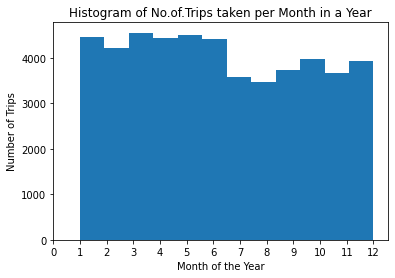

In [99]:
# Histogram of No. of Trips taken per Month in a Year
plt.hist(taxi.pickup_month, bins=12)
plt.xticks(np.arange(0,13,step=1))
plt.xlabel('Month of the Year')
plt.ylabel('Number of Trips')
plt.title('Histogram of No.of.Trips taken per Month in a Year')
plt.show()

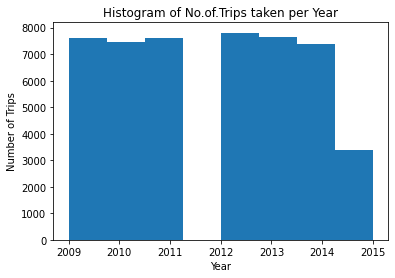

In [100]:
# Histogram of No. of Trips taken per Year
plt.hist(taxi.pickup_year, bins=8)
plt.xticks(np.arange(2009,2016,step=1))
plt.xlabel('Year')
plt.ylabel('Number of Trips')
plt.title('Histogram of No.of.Trips taken per Year')
plt.show()

In [101]:
test =  pd.read_csv('/content/test.csv')
test['pickup_datetime']=pd.to_datetime(test['pickup_datetime'],format='%Y-%m-%d %H:%M:%S UTC')

test['pickup_date']= test['pickup_datetime'].dt.date
test['pickup_day']=test['pickup_datetime'].dt.day
test['pickup_hour']=test['pickup_datetime'].dt.hour
test['pickup_day_of_week']=test['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
test['pickup_month']=test['pickup_datetime'].dt.month
test['pickup_year']=test['pickup_datetime'].dt.year

test['hav_distance']=test.apply(lambda row:haversian_distance(row['pickup_latitude'],row['dropoff_latitude'],row['pickup_longitude'],row['dropoff_longitude']),axis=1)
test['euc_distance'] = 69 * np.sqrt((np.array(test.dropoff_longitude) - np.array(test.pickup_longitude))**2 + (np.array(test.pickup_latitude) - np.array(test.dropoff_latitude))**2)

In [102]:
taxi.columns

Index(['unique_id', 'amount', 'date_time_of_pickup', 'longitude_of_pickup',
       'latitude_of_pickup', 'longitude_of_dropoff', 'latitude_of_dropoff',
       'no_of_passenger', 'pickup_date', 'pickup_hour', 'pickup_day',
       'pickup_month', 'pickup_year', 'pickup_day_of_week', 'hav_distance',
       'euc_distance'],
      dtype='object')

In [103]:
# Considering all the Features except 'Key', 'pickup_date', 'pickup_day_of_week' and 'euc_distance' (as haversian distance is already being considered, and both together could lead to redundant features.)
taxidata = taxi[taxi.columns[3:]]
taxidata = taxidata[taxidata.columns.difference(['pickup_day_of_week'])]
taxidata = taxidata[taxidata.columns.difference(['pickup_date'])]
taxidata = taxidata[taxidata.columns.difference(['euc_distance'])]

# Trainoutput is the Fare Amount column
taxioutput = taxi[taxi.columns[1:2]]

# Considering 2/3rd of the data for Training and 1/3rd for Validation
x, y = taxidata.shape
x1 = 2 * int(x / 3)

taxidata_X = taxidata[0:x1]
testdata_X = taxidata[x1:x]

taxidata_Y = taxioutput[0:x1]
testdata_Y = taxioutput[x1:x]

x, y
print (taxidata.columns)

Index(['hav_distance', 'latitude_of_dropoff', 'latitude_of_pickup',
       'longitude_of_dropoff', 'longitude_of_pickup', 'no_of_passenger',
       'pickup_day', 'pickup_hour', 'pickup_month', 'pickup_year'],
      dtype='object')


In [104]:
# Considering all Features except 'Key', 'pickup_date', 'pickup_day_of_week'
testdata = test[test.columns[2:]]
testdata = testdata[testdata.columns.difference(['pickup_day_of_week'])]
testdata = testdata[testdata.columns.difference(['pickup_date'])]
testdata = testdata[testdata.columns.difference(['euc_distance'])]

print (testdata.columns)

Index(['dropoff_latitude', 'dropoff_longitude', 'hav_distance',
       'passenger_count', 'pickup_day', 'pickup_hour', 'pickup_latitude',
       'pickup_longitude', 'pickup_month', 'pickup_year'],
      dtype='object')


In [105]:
#TRAINING USING LINEAR REGRESSION

regr = linear_model.LinearRegression()
regr.fit(taxidata_X, taxidata_Y)
testdata_Y_pred_LR = regr.predict(testdata_X)

# The coefficients
print('Coefficients: \n', regr.coef_)

# ERROR METRICS

# Root Mean Square Error
rmse = np.sqrt(mean_squared_error(testdata_Y, testdata_Y_pred_LR))
print("RMSE: %f" % (rmse))

# The Mean Squared Error
print("Mean squared error: %.2f"
      % mean_squared_error(testdata_Y, testdata_Y_pred_LR))

# R2 Score
print('Variance score: %.2f' % r2_score(testdata_Y, testdata_Y_pred_LR))

Coefficients: 
 [[ 2.83148680e+00 -1.40091100e+01 -3.12815094e+01  1.76889407e+01
   1.03697933e+01  3.85883595e-02  6.38168056e-04  9.36390447e-03
   8.59406817e-02  5.58749770e-01]]
RMSE: 5.706642
Mean squared error: 32.57
Variance score: 0.66


In [ ]:
#TRAINING USING LINEAR REGRESSION
regr = linear_model.LinearRegression()
regr.fit(taxidata_X, taxidata_Y)
testdata_Y_pred_LR = regr.predict(testdata_X)

# The coefficients
print('Coefficients: \n', regr.coef_)

# Root Mean Square Error
rmse = np.sqrt(mean_squared_error(testdata_Y, testdata_Y_pred_LR))
print("RMSE: %f" % (rmse))

# The Mean Squared Error
print("Mean squared error: %.2f"
      % mean_squared_error(testdata_Y, testdata_Y_pred_LR))

# R2 Score
print('Variance score: %.2f' % r2_score(testdata_Y, testdata_Y_pred_LR))

Coefficients: 
 [[ 2.83148680e+00 -1.40091100e+01 -3.12815094e+01  1.76889407e+01
   1.03697933e+01  3.85883595e-02  6.38168056e-04  9.36390447e-03
   8.59406817e-02  5.58749770e-01]]
RMSE: 5.706642
Mean squared error: 32.57
Variance score: 0.66


In [124]:
# TESTING ON TEST USED USING THE ABOVE MODEL
actual_testdata_pred_lr = regr.predict(taxidata)
#EXPORTING PREDICTIONS TO CSV
key = pd.DataFrame(taxi[taxi.columns[0:1]])

key['fare_amount'] = actual_testdata_pred_lr
key.to_csv('test_predictions_lr.csv')

Cross validated scores: [0.53245195 0.68084802 0.69893758 0.64124637 0.70494932 0.62856468]
Cross-Predicted Accuracy: 0.6473059840997525


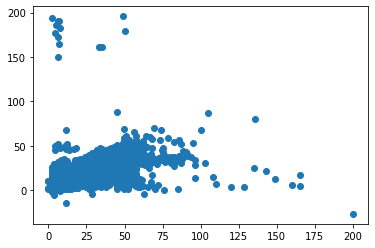

In [113]:
# USING K-FOLD CROSS VALIDATION
scores = cross_val_score(regr, taxidata, taxioutput, cv=6)
print ("Cross validated scores:", scores)
    
predictions = cross_val_predict(regr, taxidata, taxioutput, cv=6)
plt.scatter(taxioutput, predictions)

accuracy = metrics.r2_score(taxioutput, predictions)
print ("Cross-Predicted Accuracy:", accuracy)

In [125]:
actual_testdata_pred_lr = regr.predict(taxidata)
#EXPORTING PREDICTIONS TO CSV
key = pd.DataFrame(taxi[taxi.columns[0:1]])
key['fare_amount'] = actual_testdata_pred_lr
key.to_csv('test_predictions_lr_cv.csv')